# Lego Head

In [1]:
import svgwrite
from svgwrite.extensions import Inkscape
from svgwrite import cm, mm   

import numpy as np
from numpy import pi

In [2]:
def mm_to_px(mm, dpi=96):
    inch_per_mm = 0.0393701 # inch/mm
    return mm * inch_per_mm * dpi

## Dimensions

https://i.pinimg.com/originals/17/82/5b/17825b56bc6ff86b27dd6b5328b7f15a.jpg

In [3]:
# all dimensions are in mm
neck_radius = 600 / (2 * pi) # this is the anchor size. Everything else is scaled based on this value
neck_radius

95.4929658551372

In [4]:
r = 1.6 # head curvature radius, the original value is 2.0

In [5]:
# "r / 2" is because at the bottom it's approximately a quater of the torus
scaler = neck_radius / ((10.2 - 2 * r / 2) / 2)

In [6]:
neck_height = 1 * scaler
neck_height

22.207666477938886

In [7]:
torus_cross_radius = r * scaler # torus cross section radius
torus_cross_radius

35.53226636470222

In [8]:
head_radius = (10.2 / 2) * scaler
head_radius

113.25909903748831

In [9]:
head_height = (9.0 - 2 * r) * scaler # the original value is 8.5
head_height

128.80446557204553

In [10]:
# eye_top_offset = (3.8 - r) * scaler
eye_top_offset = head_height / 2
eye_dist = 2.9 * scaler
eye_radius = 0.5 * scaler
eye_top_offset, eye_dist, eye_radius

(64.40223278602276, 64.40223278602276, 11.103833238969443)

In [11]:
mouth_top_offset = head_height * 4 / 5
mouth_top_offset

103.04357245763643

In [12]:
head_top_radius = (10.2 - 2 * r) / 2 * scaler
head_top_radius

77.72683267278609

In [13]:
stud_radius = (4.9 / 2) * scaler # top of the head stud radius
stud_radius

54.408782870950276

In [14]:
stud_height = 1.78 * scaler
stud_height

39.52964633073122

In [15]:
margin = 5 # print margin, mm
stroke_width = '0.01mm'
tab_offset = 10 # mm

line_style = {
    'stroke_width': stroke_width,
    'stroke': 'black',
    'fill': 'none'
}

# due to a bug in inkscape 'stroke_dasharray' must be set to pixels
dashed_line_style = {
    'stroke_width': stroke_width,
    'stroke': 'black',
    'fill': 'none',
    'stroke_dasharray': mm_to_px(2),
    'stroke_dashoffset': mm_to_px(2)
}

## Draw top half torus

In [16]:
n_cross = 12 # number of sides in the cross section of the torus
assert n_cross % 4 == 0 # torus -> polygon math needs to be checked for n_cross % 4 != 0

In [17]:
n_equator = 16 # number of sides along the equator of the torus

In [18]:
alpha_cross = 2 * pi / n_cross
alpha_equator = 2 * pi / n_equator

In [19]:
cross_side = 2 * torus_cross_radius * np.sin(alpha_cross / 2) # side length along longitude (vertical)
cross_side

18.39285450168129

In [20]:
lats = []
for i in range(-1, n_cross // 4 + 2):
    ri = head_radius - (torus_cross_radius - torus_cross_radius * np.cos(i * alpha_cross))
    lat = 2 * ri * np.sin(alpha_equator / 2)
    lats.append(lat)
lats

[42.334084058163064,
 44.191508204960314,
 42.334084058163064,
 37.259506917907714,
 30.32750563085511,
 23.395504343802518]

In [21]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_mm(self):
        # return (self.x * mm, self.y * mm)
        return (mm_to_px(self.x), mm_to_px(self.y))
    
    def to_np(self):
        return np.array([self.x, self.y], dtype=float)

class Polyline:
    def __init__(self, points):
        assert len(points) >= 2
        self.points = points
        
    def draw(self, container, **style):
        path = svgwrite.path.Path(d=('M', *self.points[0].to_mm()), **style)
        for p in self.points[1:]:
            path.push('L', *p.to_mm())
        container.add(path)
        return self

In [22]:
def rotate(xy, radians):
    x, y = xy
    xx = x * np.cos(radians) + y * np.sin(radians)
    yy = -x * np.sin(radians) + y * np.cos(radians)

    return np.array([xx, yy], dtype=float)

def create_tab(line, offset):
    a, b = line.points
    a = a.to_np()
    b = b.to_np()
    
    u = (b - a) / np.linalg.norm(b - a) # unit vector a -> b
    
    a_step = offset * rotate(u, -pi/4)
    b_step = offset * rotate(-u, -3*pi/4)

    at = a + a_step
    bt = b - b_step

    return Polyline([Point(*a), Point(*at), Point(*bt), Point(*b)])

In [23]:
n_copies = 4

In [24]:
canvas_width = mm_to_px(n_copies * (np.max(lats) + tab_offset + margin) + margin)
canvas_height = mm_to_px(len(lats) * cross_side + margin)

In [25]:
dwg = svgwrite.Drawing('top-half-torus.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
tmp_layer = inkscape.layer(label="temp", locked=False)

a1 = b1 = None
a2 = b2 = None

for i, l in enumerate(lats):
    a1, b1 = a2, b2
    
    a2 = Point(-l / 2, i * cross_side)
    b2 = Point(l / 2, i * cross_side)
    
    if i == 0 or i == len(lats) - 1:
        Polyline([a2, b2]).draw(tmp_layer, **line_style)
    else:
        Polyline([a2, b2]).draw(tmp_layer, **dashed_line_style)
        
    if i == 0:
        continue
    
    left_lon_line = Polyline([a1, a2]).draw(tmp_layer, **dashed_line_style)
    right_lon_line = Polyline([b1, b2]).draw(tmp_layer, **line_style)
    
    create_tab(left_lon_line, tab_offset).draw(tmp_layer, **line_style)    

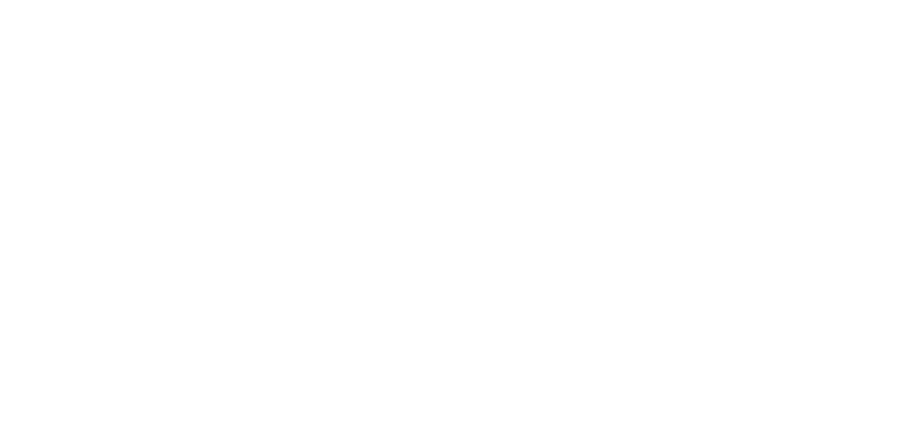

In [26]:
layer = inkscape.layer(label="lego", locked=False)

# position copies on the canvas
for c in range(n_copies):
    for e in tmp_layer.elements:
        e = e.copy()
        offset_x = mm_to_px(c * (np.max(lats) + tab_offset) + np.max(lats) / 2 + tab_offset)
        offset_y = mm_to_px(margin)
        e.translate(offset_x , offset_y)
        layer.add(e)

dwg.add(layer)
dwg.save()
dwg

## Draw face

In [27]:
width = (2 * pi * head_radius) / 2 + tab_offset # the face has 2 equal parts: front and back
height = head_height
width, height

(365.8139534883721, 128.80446557204553)

In [28]:
canvas_width = mm_to_px(width + 10)
canvas_height = mm_to_px(height + 10)

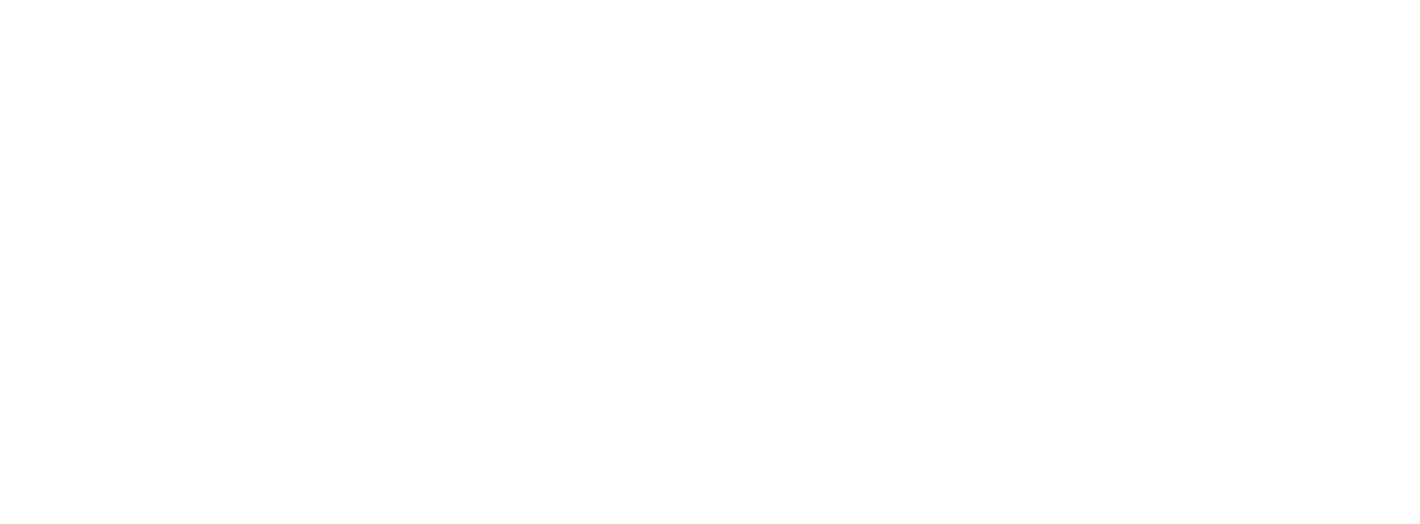

In [29]:
dwg = svgwrite.Drawing('face_back.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

rect = dwg.rect(insert=(0,0), size=(mm_to_px(width), mm_to_px(height)), **line_style)
layer.add(rect)

tab_line = dwg.line(start=(mm_to_px(width - tab_offset), 0),
                    end=(mm_to_px(width - tab_offset), mm_to_px(height)), **dashed_line_style)
layer.add(tab_line)
layer.translate(mm_to_px(margin), mm_to_px(margin))
dwg.add(layer)

dwg.save()
dwg

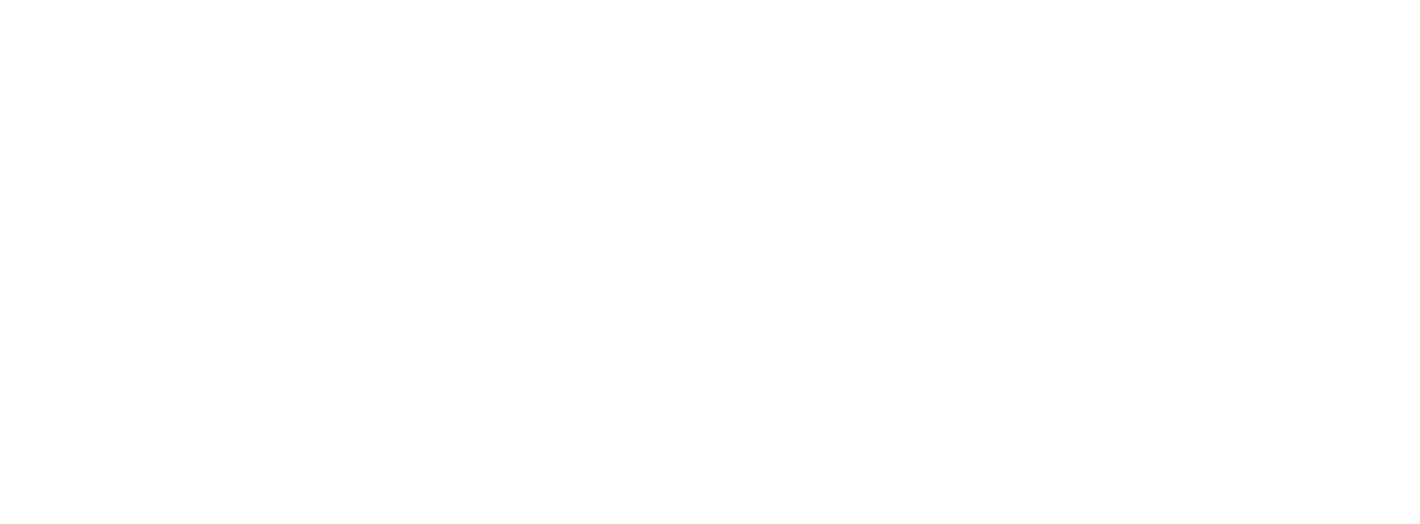

In [30]:
dwg = svgwrite.Drawing('face_front.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

rect = dwg.rect(insert=(0,0), size=(mm_to_px(width), mm_to_px(height)), **line_style)
layer.add(rect)

tab_line = dwg.line(start=(mm_to_px(width - tab_offset), 0),
                    end=(mm_to_px(width - tab_offset), mm_to_px(height)), **dashed_line_style)
layer.add(tab_line)

left_eye_x = mm_to_px(width/2 - eye_dist/2)
left_eye_y = mm_to_px(eye_top_offset)
left_eye = dwg.circle(center=(left_eye_x, left_eye_y),
                      r=mm_to_px(eye_radius),
                      **line_style)
layer.add(left_eye)

right_eye_x = mm_to_px(width/2 + eye_dist/2)
right_eye_y = mm_to_px(eye_top_offset)
right_eye = dwg.circle(center=(right_eye_x, right_eye_y),
                       r=mm_to_px(eye_radius),
                       **line_style)
layer.add(right_eye)

mouth = dwg.path(d=('M', left_eye_x, mm_to_px(mouth_top_offset)), **line_style)
mouth.push('Q', mm_to_px(width/2), mm_to_px(1.3 * mouth_top_offset), right_eye_x, mm_to_px(mouth_top_offset))
# mouth.push('Z')
mouth.push('M', left_eye_x, mm_to_px(mouth_top_offset))
mouth.push('Q', mm_to_px(width/2), mm_to_px(1.1 * mouth_top_offset), right_eye_x, mm_to_px(mouth_top_offset))
layer.add(mouth)

layer.translate(mm_to_px(margin), mm_to_px(margin))
dwg.add(layer)

dwg.save()
dwg


## Draw head top

In [31]:
canvas_width = mm_to_px(2 * head_top_radius + margin)
canvas_height = mm_to_px(2 * head_top_radius + margin)

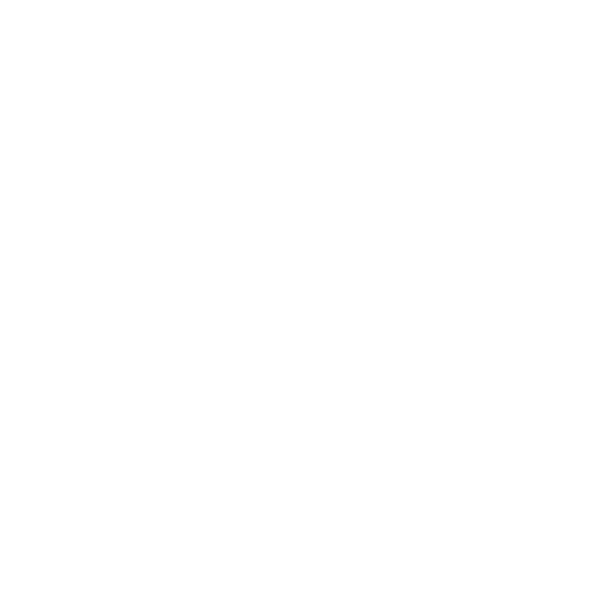

In [32]:
dwg = svgwrite.Drawing('head_top.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

top = dwg.circle(center=(canvas_width/2, canvas_height/2),
                 r=mm_to_px(head_top_radius),
                 **line_style)

stud_line = dwg.circle(center=(canvas_width/2, canvas_height/2),
                       r=mm_to_px(stud_radius),
                       **dashed_line_style)


layer.add(top)
layer.add(stud_line)
dwg.add(layer)
dwg

In [33]:
dwg.save()

## Draw top stud

In [34]:
n_tabs = 32

In [35]:
width = 2 * pi * stud_radius
height = stud_height
width, height

(341.8604651162791, 39.52964633073122)

In [36]:
canvas_width = mm_to_px(width + tab_offset + margin)
canvas_height = mm_to_px(height + 2 * tab_offset + margin)

In [37]:
n_steps = n_tabs + 1
step = width / (n_steps)
step

10.35940803382664

In [38]:
top_points = []
bottom_points = []

for i in range(n_steps):
    if i % 2 == 1:
        y_top = -tab_offset
        y_bottom = height + tab_offset
    else:
        y_top = 0
        y_bottom = height

    top_points.extend([Point(i * step, y_top), Point((i + 1) * step, y_top)])
    bottom_points.extend([Point(i * step, y_bottom), Point((i + 1) * step, y_bottom)])

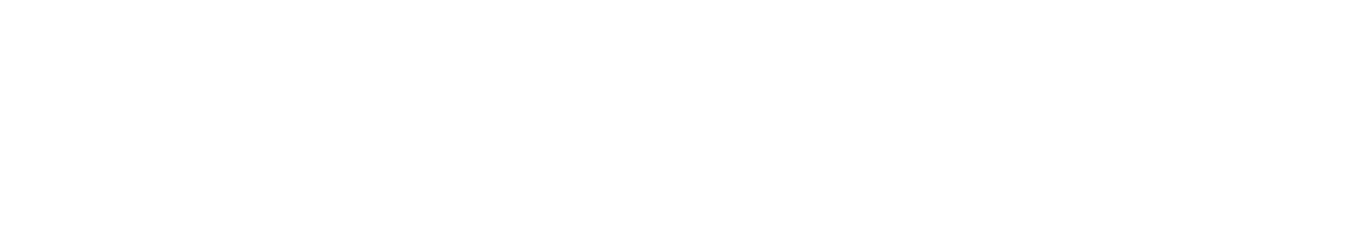

In [39]:
dwg = svgwrite.Drawing('stud.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

Polyline(top_points).draw(layer, **line_style)
Polyline(bottom_points).draw(layer, **line_style)

for i in range(1, len(top_points)-1, 4):
    Polyline([top_points[i], top_points[i+3]]).draw(layer, **dashed_line_style)
    Polyline([bottom_points[i], bottom_points[i+3]]).draw(layer, **dashed_line_style)

tab_line = Polyline([bottom_points[-1], top_points[-1]])
tab_line.draw(layer, **dashed_line_style)
create_tab(tab_line, tab_offset).draw(layer, **line_style)

Polyline([bottom_points[0], top_points[0]]).draw(layer, **line_style)

layer.translate(mm_to_px(margin), mm_to_px(tab_offset + margin))
dwg.add(layer)
dwg

In [40]:
dwg.save()

## Draw stud top

In [41]:
canvas_width = mm_to_px(2 * stud_radius + margin)
canvas_height = mm_to_px(2 * stud_radius + margin)

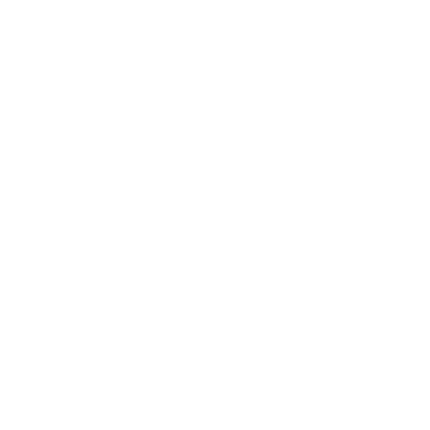

In [42]:
dwg = svgwrite.Drawing('stud_top.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

top = dwg.circle(center=(canvas_width/2, canvas_height/2),
                 r=mm_to_px(stud_radius),
                 **line_style)
layer.add(top)
dwg.add(layer)
dwg

In [43]:
dwg.save()

## Draw bottom half torus

In [44]:
# bottom torus has 2 less side
bottom_lats = []
for i in range(-1, n_cross // 4):
    ri = head_radius - (torus_cross_radius - torus_cross_radius * np.cos(i * alpha_cross))
    lat = 2 * ri * np.sin(alpha_equator / 2)
    bottom_lats.append(lat)
bottom_lats

[42.334084058163064,
 44.191508204960314,
 42.334084058163064,
 37.259506917907714]

In [45]:
canvas_width = mm_to_px(n_copies * (np.max(bottom_lats) + tab_offset + margin) + margin)
canvas_height = mm_to_px(len(bottom_lats) * cross_side + margin)

In [46]:
dwg = svgwrite.Drawing('bottom-half-torus.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
tmp_layer = inkscape.layer(label="temp", locked=False)

a1 = b1 = None
a2 = b2 = None

for i, l in enumerate(bottom_lats):
    a1, b1 = a2, b2
    
    a2 = Point(-l / 2, i * cross_side)
    b2 = Point(l / 2, i * cross_side)
    
    if i == 0 or i == len(bottom_lats) - 1:
        Polyline([a2, b2]).draw(tmp_layer, **line_style)
    else:
        Polyline([a2, b2]).draw(tmp_layer, **dashed_line_style)
        
    if i == 0:
        continue
    
    left_lon_line = Polyline([a1, a2]).draw(tmp_layer, **dashed_line_style)
    right_lon_line = Polyline([b1, b2]).draw(tmp_layer, **line_style)
    
    create_tab(left_lon_line, tab_offset).draw(tmp_layer, **line_style)    

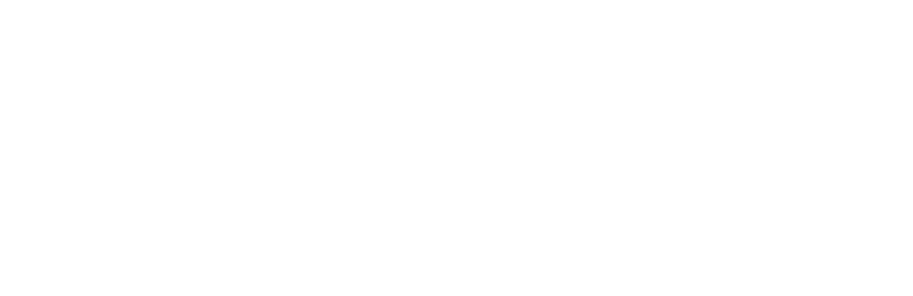

In [47]:
layer = inkscape.layer(label="lego", locked=False)

# position copies on the canvas
for c in range(n_copies):
    for e in tmp_layer.elements:
        e = e.copy()
        offset_x = mm_to_px(c * (np.max(bottom_lats) + tab_offset) + np.max(bottom_lats) / 2 + tab_offset)
        offset_y = mm_to_px(margin)
        e.translate(offset_x , offset_y)
        layer.add(e)

dwg.add(layer)
dwg.save()
dwg

## Draw neck ring

In [48]:
ring_outer_radius = bottom_lats[-2] * n_equator / (2 * pi)
ring_inner_radius = bottom_lats[-1] * n_equator / (2 * pi)
ring_outer_radius, ring_inner_radius

(107.8028598259913, 94.88055525042692)

In [49]:
canvas_width = mm_to_px(2 * ring_outer_radius + margin)
canvas_height = mm_to_px(2 * ring_outer_radius + margin)

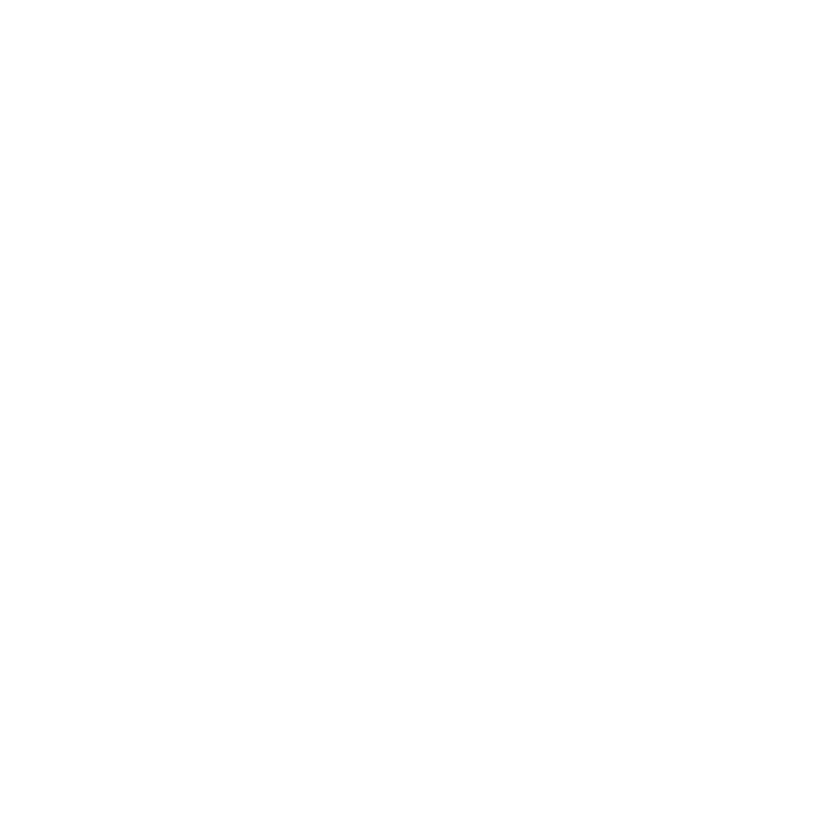

In [50]:
dwg = svgwrite.Drawing('neck_ring.svg', profile='full', size=(canvas_width, canvas_height))
inkscape = Inkscape(dwg)
layer = inkscape.layer(label='lego', locked=False)

outer_points = []
inner_points = []
for i in range(n_equator + 1):
    outer_points.append(Point(ring_outer_radius * np.cos(i * alpha_equator),
                              ring_outer_radius * np.sin(i * alpha_equator)))
    inner_points.append(Point(ring_inner_radius * np.cos(i * alpha_equator),
                              ring_inner_radius * np.sin(i * (alpha_equator))))

Polyline(outer_points).draw(layer, **line_style)
Polyline(inner_points).draw(layer, **line_style)

layer.translate(canvas_width / 2, canvas_height / 2)

dwg.add(layer)
dwg.save()
dwg